# Model 1 Logistic Regression for Predicting normal blood pressure, high blood pressure, and very high blood pressure 

# Dependancies

In [359]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
#load in data
df = pd.read_csv("cardio_train.csv", sep=";")

# Clean data

Removing invalid values per our Exploratory Data Analysis document

This data has values for weight, height and blood pressure that are not possible for living people. We decided that these were errors and are removing them. Body Mass Index (BMI) and Blood Pressure ranges are calculated. See the below codes for in depth analysis

# Weight and Height Clean-up

In [360]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]


# Blood Pressure Clean-Up and categories

In [648]:
# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
# bp is 1 - 5 where 1 is Normal, 2 is Elevated, 3 is HyperTension Stage1, 4 is HyperTensions Stage2, 5 is Hypertension Stage3
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp1'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3'])

# Make a 3 way clasification
df['bp2'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, df.bp2)
df['bp2'] = np.where((df.ap_hi >= 120) & (df.ap_hi <= 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 2, df.bp2)
df['bp2'] = np.where((df.ap_hi > 140) | (df.ap_lo >= 90), 3, df.bp2)


We decided to use the 3 level clasification of blood presure in base of common practical application, eventhough this is not the official clasification from the American Heart Association, it is very often used in practice.

1= Normal Blood Pressure
2= Hight Blood Pressure
3= Very hight Blood Pressure

# Calculate BMI (Body Mass Index)

In [649]:
# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bp,bp1,bp2,bmi
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,4,Hyper_Stage2,3,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,3,Hyper_Stage1,2,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,4,Hyper_Stage2,3,28.710479
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,3,Hyper_Stage1,2,29.384676
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,3,Hyper_Stage1,2,37.729725


In [650]:
df["bp2"].unique

<bound method Series.unique of 1        3
2        2
3        3
5        2
6        2
        ..
69995    2
69996    3
69997    3
69998    2
69999    2
Name: bp2, Length: 53053, dtype: int64>

# Delete unuse columns

In [651]:
df1= df[['bmi','gender','weight','cardio', 'bp2']]
df1.head()

,bmi,gender,weight,cardio,bp2
1,34.927679,1,85.0,1,3
2,23.507805,1,64.0,1,2
3,28.710479,2,82.0,1,3
5,29.384676,1,67.0,0,2
6,37.729725,1,93.0,0,2


# Creating the one agaist the other classifier

we are using for the logistic regresion model, 10-k fold validation, in order to use all the data for the training of the model in this multi class outcome. We use this algorithm for the test train data split and for the grid seach performance below.  

In [652]:
#set X with our desired variables

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values

# create cross validation iterator
kf = KFold(n_splits=10, random_state=None, shuffle=False)


for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

# Fit an independent logistic regression model for each class using the OneVsRestClassifier wrapper.
base_lr = LogisticRegression(LogisticRegression(solver = 'lbfgs', max_iter=10000, multi_class= 'ovr'))
ovr = OneVsRestClassifier(base_lr)



We let all the variables from df to run through the LR model builded below, but 'bmi','gender','weight','cardio' alone performed the same way as putting all the variables in the model. So we choose for simplicity to use the 4 variables just mentioned. 

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. 

We will be performing the ovr and the multinomial algotithm in our multi class outcome of blood pressure normal, high and very high. Let start with the one vs the others.

# Creating a grid search to find the best parameter

Hyperparameters sets the algorithm that can be adjusted to optimize performance, these are the knobs to generate optimal outcome. These Hyperparameters in machine learning model help define your model architecture. Leveraging grid search optimal automated exploration is launched to find the optimal parameter value to extract best model architecture. 

The project Grid search approach was used to tune the parameters of the model. Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. However, grid search suffers from the curse of dimensionality: the number of times required to evaluate the model during hyperparameter optimization grows exponentially in the number of parameters. 


In the model building Grid Search was used. In the model tuning process, three parameters were considered: C, penalty and Solver. 

<b>C:</b> This controls the complexity and simplicity of model. However, complexity can lead to over fitting vs. simplicity will lead to under fitting. Small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C the power of regularization is decreased which allows the model to increase its complexity, and therefore, overfit the data. 

<b>Penalty:</b> This model uses penalties L2. The Penalty is used to specify the penalization method of the coefficients of noncontributing or less contributing variables. Ridge (L2) all variables are included in the model, though some are shrunk (but not to zero like L1 Penalty. Less computationally intensive than lasso. We decided to use (L2) becouse it is the only one supported by our choosen solver explained below.

<b>Solver:</b> Are the algorithm used in Logistic Regression to predict the outcome. Default value is lbfgs. Other possible values (to list few) are, liblinear, sag and saga.
liblinear − It is a good choice for small datasets. We have a relative large dataset, this is why we decided to use lbfgs. 
lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty. The other possible solver sag and sage perform similar to lbfgs. 

Finally in the grid search we use the 10 fold K validation stated in the code above, and we used for scoring in the grid search the F1-score average of the whole model which is the f1_micro. 


In [653]:
#Create a Linear Regression object and perform a grid search to find the best parameters
ovr

#parameters = [{'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}]
parameters = {
    "estimator__C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "estimator__penalty":["l2"]
}


#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=ovr
                   , param_grid=parameters
                   , cv= kf # KFolds = 10
                   , scoring='f1_micro')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty=LogisticRegression(C=1.0,
     

# Print the test score per parameter

In [654]:
regGridSearch.cv_results_['mean_test_score']
results_LR_one_other = pd.DataFrame(regGridSearch.cv_results_['params'])
results_LR_one_other['test_score'] = regGridSearch.cv_results_['mean_test_score']
results_LR_one_other

,estimator__C,estimator__penalty,test_score
0,100.0000,l2,0.679924
1,10.0000,l2,0.679924
2,1.0000,l2,0.679924
3,0.1000,l2,0.679903
4,0.0100,l2,0.679044
5,0.0010,l2,0.669766
6,0.0001,l2,0.648027


The test score is very consistent among the different stimator c with penalization L2 (Ridge)

# Printing the grid best Estimator

In [655]:
ovr= regGridSearch.best_estimator_
ovr

OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

# Using the grib best stimator and predict

In [656]:
ovr.fit(X_train, y_train)
y_hat = ovr.predict(X_test)

# Performance of the model = Metrics

In [657]:
# how did our model perform?
count_misclassified = (y_test != y_hat).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_hat)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test, y_hat, average='micro')
print("Precision=", precision)
recal = metrics.recall_score(y_test, y_hat, average='micro')
print("Recal=", recal)
fscore = metrics.f1_score(y_test, y_hat, average='weighted')
print("fscore=",fscore )
# Confusion matrix
cm= multilabel_confusion_matrix(y_test, y_hat)
print("Confusion Matrix =", cm)

Misclassified samples: 1720
Accuracy: 0.68
Precision= 0.6757775683317625
Recal= 0.6757775683317625
fscore= 0.6671216995215014
Confusion Matrix = [[[5292    0]
  [  13    0]]

 [[ 926 1038]
  [ 679 2662]]

 [[2672  682]
  [1028  923]]]


Micro option calculates TP,FP etc. globally, while macro does it specific to each class and averages them. Weighted is the weighted version of macro average that accounts for class imbalance.

As you can see above we have a general accuracy of the model of 68 %. There is a total 1720 misclasified outcome. 

The gloval precision of the model is is 67 %. Precision represents the number of correctly identified positive results divided by the number of all positive results.  

The gloval recall of the model is 67 %. The recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. 


And acounting for the class inbalance, the the average of each class f score is 0.66. The f score is a harmonic mean of precision and recall. It is calculated from the precision and recall of the test. 

# Plot the confusion matrix

Confusion matrix, without normalization
[[   0   10    3]
 [   0 2662  679]
 [   0 1028  923]]
Normalized confusion matrix
[[0.   0.77 0.23]
 [0.   0.8  0.2 ]
 [0.   0.53 0.47]]


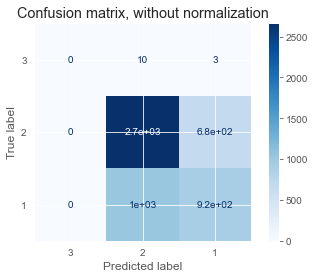

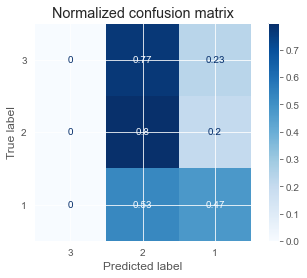

In [658]:
#set X and y with our desired variables

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values
class_names = df.bp2.unique()

# Split the data into a training set and a test set
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
# Run classifier, using a model that is too regularized (C too low) to see the impact on the results

classifier = ovr.fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


# ROC Curve one versus the others

Below you can see the ROC curve for each class. The clasification of normal blood pressure against the other class high and very high blood pressure,  has a lower area under the curve than the possibility of classifing high or very high blodd pressure against the other class. Also the clasification of high blood pressure agains the other class has the same area under the curve than the very high clasification of blood pressure.

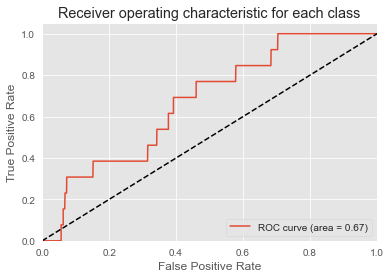

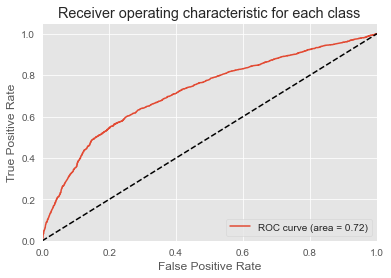

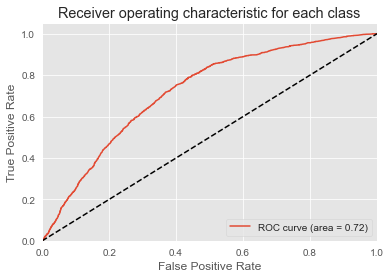

In [659]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values
y = label_binarize(y, classes=[1,2,3])
n_classes = 3

# shuffle and split training and test sets
kf = KFold(n_splits=10)
KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
# classifier
y_score = ovr.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()


# Extention of the ROC for multi class logistic Regression one vs the others

Micro option calculates TP,FP etc. globally, while macro does it specific to each class and averages them. You can see in the below extention of the ROC for multi level clasification that the gloval ROC of the model is 83 % and the average ROC of the class is 70 %. The ROC per class is the same as the ROC showing above. 

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


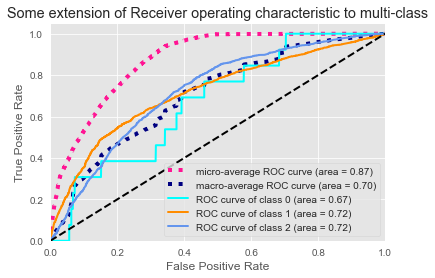

In [662]:
from scipy import interp
from itertools import cycle

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Interpretation of the weight

I need to do this

bmi has weight of 0.04702146822970083
gender has weight of -0.38592695081943673
weight has weight of -0.029773020217359652
cardio has weight of -1.423073262587441


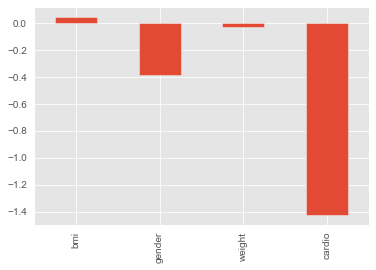

In [661]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# iterate over the coefficients
clf= ovr.fit(X_train, y_train)
weights = clf.coef_.T # take transpose to make a column vector
variable_names = ['bmi','gender','weight','cardio']
 
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
weights = pd.Series(clf.coef_[0],index= variable_names)
weights.plot(kind='bar')
plt.show()

# Creating a multi-class classifier with the multinomial logistic regression algorithm

We are performing the ovr and the multinomial algotithm in our multi class outcome of blood pressure normal, high and very high. Previously we did the one vs the others, now we will perform the multinomial algorithm in logistic regression.

In [601]:
#set X with our desired variables

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values

# create cross validation iterator
kf = KFold(n_splits=10, random_state=None, shuffle=False)


for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        

# Logistic regression model for the multiclass clasifier
model = LogisticRegression(solver = 'lbfgs', max_iter=10000, multi_class= 'multinomial')



# Grid search for the best parameter

We performs the grid search the same way as the gid search for one vs the others, please refer to the grid search explanation above.

In [602]:
#Create a Linear Regression object and perform a grid search to find the best parameters
model
parameters = {"C":np.logspace(-3,3,7), "penalty":["l2"]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=model
                   , param_grid=parameters
                   , cv= kf # KFolds = 10
                   , scoring='f1_micro')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_train, y_train)# use the model to make predictions with the test data

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=

# Print the test score per parameter

The test score is very consistent among the diferent C.

In [603]:
regGridSearch.cv_results_['mean_test_score']
results_LR_one_other = pd.DataFrame(regGridSearch.cv_results_['params'])
results_LR_one_other['test_score'] = regGridSearch.cv_results_['mean_test_score']
results_LR_one_other


,C,penalty,test_score
0,0.001,l2,0.674981
1,0.010,l2,0.679484
2,0.100,l2,0.679903
3,1.000,l2,0.679966
4,10.000,l2,0.680008
5,100.000,l2,0.680049
6,1000.000,l2,0.680091


# Print the best parameter

In [604]:
#Perform hyperparameter search to find the best combination of parameters for our data
model= regGridSearch.best_estimator_
model

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Predict with the best parameter

In [605]:
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

# Get the performance of the model

As you can see above we have a general accuracy of the model of 68%. There is a total 1492 misclasified outcome. 

The gloval precision of the model is is 67 %. Precision represents the number of correctly identified positive results divided by the number of all positive results.  

The gloval recall of the model is 67 %. The recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. 


And acounting for the class inbalance, the the average of each class f score is 0.66. The f score is a harmonic mean of precision and recall. It is calculated from the precision and recall of the test. 

This metric of performance in the multinomial logistic regresion model is similar to the one versus the other algorithm in the logistic regresion model

In [606]:
# how did our model perform?
count_misclassified = (y_test != y_hat).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_hat)
print('Accuracy: {:.2f}'.format(accuracy))
precision = metrics.precision_score(y_test, y_hat, average='micro')
print("Precision=", precision)
recal = metrics.recall_score(y_test, y_hat, average='micro')
print("Recal=", recal)
fscore = metrics.f1_score(y_test, y_hat, average='weighted')
print("fscore=",fscore )
# Confusion matrix
cm= multilabel_confusion_matrix(y_test, y_hat)
print("Confusion Matrix =", cm)

Misclassified samples: 1722
Accuracy: 0.68
Precision= 0.6754005655042413
Recal= 0.6754005655042413
fscore= 0.6667359665786629
Confusion Matrix = [[[5292    0]
  [  13    0]]

 [[ 925 1039]
  [ 680 2661]]

 [[2671  683]
  [1029  922]]]


# Plot the confusion matrix

Confusion matrix, without normalization
[[   0   10    3]
 [   0 2661  680]
 [   0 1029  922]]
Normalized confusion matrix
[[0.   0.77 0.23]
 [0.   0.8  0.2 ]
 [0.   0.53 0.47]]


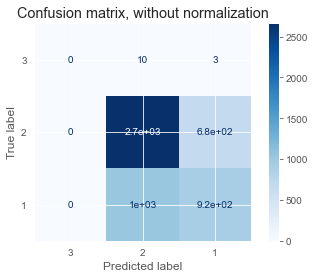

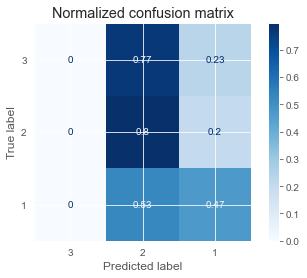

In [607]:
#set X with our desired variables

X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values
class_names = df.bp2.unique()

# Split the data into a training set and a test set
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

classifier = model.fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


# Plot the weight

I need to explain this

bmi has weight of -0.0030594149255365076
gender has weight of -0.4356319973338589
weight has weight of -0.025731238586851318
cardio has weight of -1.1694688733101888


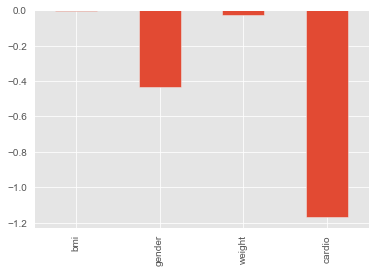

In [608]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# iterate over the coefficients
clf= model.fit(X_train, y_train)
weights = clf.coef_.T # take transpose to make a column vector
variable_names = ['bmi','gender','weight','cardio']
 
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
weights = pd.Series(clf.coef_[0],index= variable_names)
weights.plot(kind='bar')
plt.show()

# ROC Curve for the classifier by class

Below you can see the ROC curve for each class. The clasification of normal blood pressure against the other class high and very high blood pressure,  has a lower area under the curve than the possibility of classifing high or very high blodd pressure against the other class. Also the clasification of high blood pressure agains the other class has the same area under the curve than the very high clasification of blood pressure.

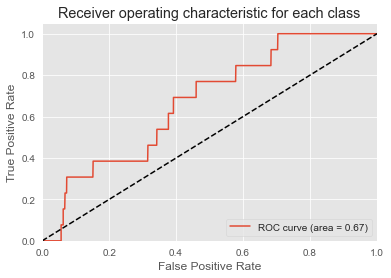

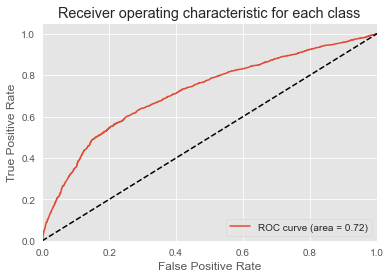

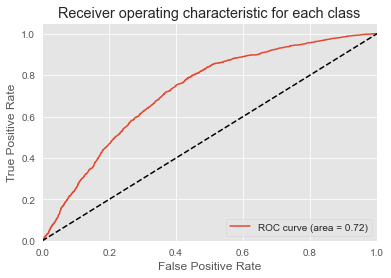

In [663]:
X = df1[['bmi','gender','weight','cardio']].values  
y = df1['bp2'].values
y = label_binarize(y, classes=[1,2,3])
n_classes = 3

# shuffle and split training and test sets
kf = KFold(n_splits=10)
KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
# classifier we use one versus the other to plot the fiferents class
classifier = OneVsRestClassifier(model)
y_score = classifier .fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()


# ROC Curve for the classifier computing micro-average ROC and macro-average

The result as there is not surprise is similar to the previous model

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


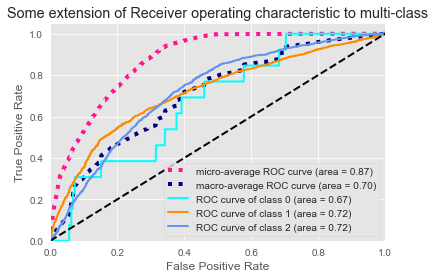

In [610]:
from scipy import interp
from itertools import cycle

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Knn Model

In [311]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [312]:
df = df[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio','bp']]
df.head()

,age,bmi,cholesterol,gluc,smoke,alco,active,cardio,bp
1,20228,34.927679,3,1,0,0,1,1,4
2,18857,23.507805,3,1,0,0,0,1,3
3,17623,28.710479,1,1,0,0,1,1,4
5,21914,29.384676,2,2,0,0,0,0,3
6,22113,37.729725,3,1,0,0,1,0,3


In [313]:
scaler = StandardScaler()
scaler.fit(df.drop(['bp'],axis=1))
scaled_features = scaler.transform(df.drop(['bp'],axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,age,bmi,cholesterol,gluc,smoke,alco,active,cardio
0,0.228071,1.326219,2.265255,-0.410419,-0.314747,-0.24278,0.500041,0.888532
1,-0.344422,-0.898524,2.265255,-0.410419,-0.314747,-0.24278,-1.999835,0.888532
2,-0.859708,0.115026,-0.561279,-0.410419,-0.314747,-0.24278,0.500041,0.888532
3,0.932101,0.246368,0.851988,1.276832,-0.314747,-0.24278,-1.999835,-1.125451
4,1.015198,1.872094,2.265255,-0.410419,-0.314747,-0.24278,0.500041,-1.125451


### Train Test Split
Use train_test_split to split your data into a training set and a testing set.

In [314]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['bp'],
                                                    test_size=0.20)

### Using KNN
Import KNeighborsClassifier from scikit learn.

KNN is simple to use and can return very accurate and meaningful results. It also tends to be computationally expensive, so it may not be your best choice for more massive datasets. For a larger dataset with binary classification, a simple logistic regression may be a better choice. In other cases, a random forest classifier could be a better choice. It is always a good idea to try out as many models as possible to get the most accurate machine learning predictions.

In [316]:
#Create a KNN model instance with n_neighbors=1
knn = KNeighborsClassifier(n_neighbors=1)
#Fit this KNN model to the training data.
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

#### Predictions and Evaluations
Let's evaluate our KNN model!

In [317]:
#Use the predict method to predict values using your KNN model and X_test
pred = knn.predict(X_test)

# Create a confusion matrix and classification report.

In [320]:
print(confusion_matrix(y_test,pred))

[[   1    1   16    7    0]
 [   0   36  304  137    3]
 [  25  347 3408 1845   10]
 [   8  139 1890 2397    9]
 [   0    2    7   19    0]]


# Metrics

In [321]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.03      0.04      0.03        25
           2       0.07      0.07      0.07       480
           3       0.61      0.60      0.61      5635
           4       0.54      0.54      0.54      4443
           5       0.00      0.00      0.00        28

    accuracy                           0.55     10611
   macro avg       0.25      0.25      0.25     10611
weighted avg       0.55      0.55      0.55     10611



### Choosing a K Value
Let's go ahead and use the elbow method to pick a good K Value!

** Create a for loop that trains various KNN models with different k values, then keep track of the error_rate for each of these models with a list. Refer to the lecture if you are confused on this step.**

Text(0, 0.5, 'Error Rate')

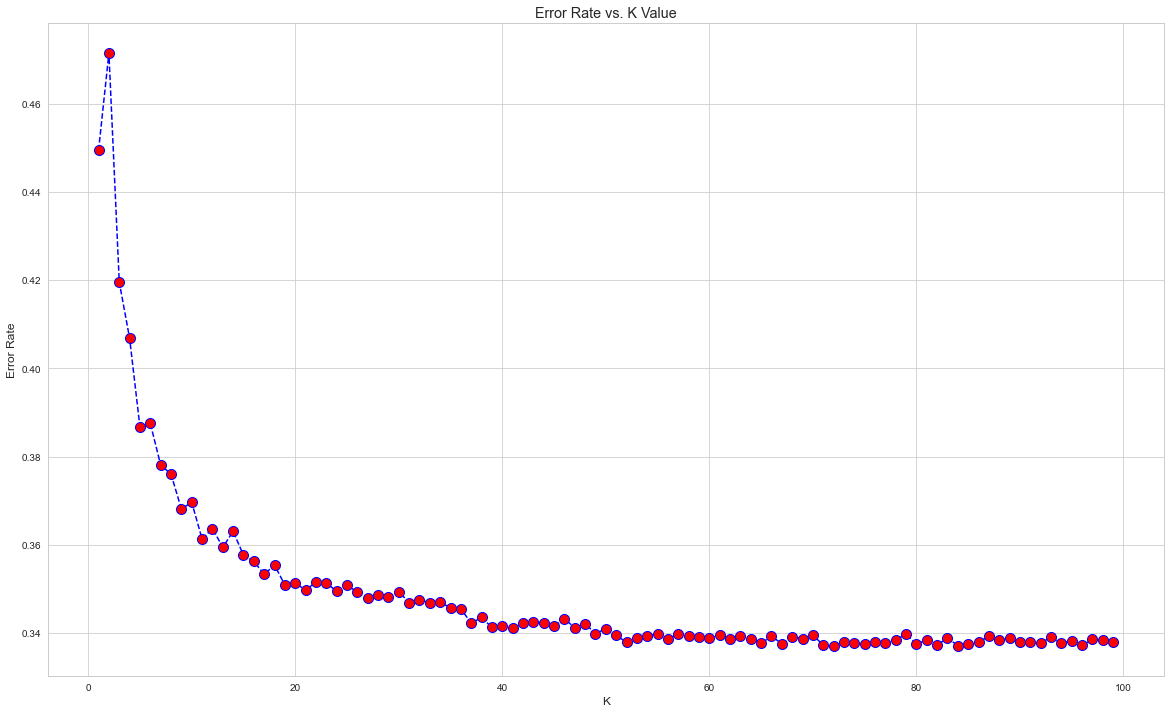

In [322]:
error_rate = []

# Will take some time
for i in range(1,100):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

    
plt.figure(figsize=(20,12))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

#### KNN is a GridSearchCV
The most common hyperparameters that impact the KNN model in terms of overfitting and underfitting are discussed below.

n_neighbor = this defines how many neighbors should be taken into account to predict the new values. 

weight=  this parameter can be set to either 'uniform', where each neighbor within the boundary carries the same weight, or 'distance' where closer points will be more heavily weighted toward the decision. Note that when weights = 'distance,' the class with the highest number in the boundary may not "win the vote."

 metric = refers to how the distance of neighboring points is chosen from the unknown point. As modeling is generally done in more than three dimensions, this can be difficult to visualize.


In [323]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
print('Train Score',knn.score(X_train,y_train))
print('Test Score',knn.score(X_test,y_test))

Train Score 0.7287121247820555
Test Score 0.6133257939873716


In [324]:
from sklearn.model_selection import cross_val_score

grid_param = {
    #'k_range' = list(range(1,100))
    'n_neighbors': [5,19,21,27,28,29,40,41,75,77],
    'weights': ['uniform','distance'],
    'metric' : ['euclidean','manhattan', 'Minkowski']
}

gs = GridSearchCV(
KNeighborsClassifier(),
grid_param,
verbose = 1, # verbose: the higher, the more messages
cv = 5,
n_jobs = -1,
return_train_score=True,
scoring = 'accuracy'
)
gs_results = gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:  4.7min remaining:   14.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


In [347]:
gs_results.best_score_

0.6609256431980667

In [357]:
gs_results.cv_results_['mean_test_score']

array([0.61, 0.6 , 0.65, 0.63, 0.65, 0.64, 0.65, 0.64, 0.65, 0.64, 0.65,
       0.64, 0.66, 0.65, 0.66, 0.65, 0.66, 0.65, 0.66, 0.65, 0.61, 0.6 ,
       0.65, 0.63, 0.65, 0.64, 0.65, 0.64, 0.65, 0.64, 0.65, 0.64, 0.66,
       0.65, 0.66, 0.65, 0.66, 0.65, 0.66, 0.65,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan])

In [349]:
results_KNN = pd.DataFrame(gs_results.cv_results_['params'])
results_KNN['test_score'] = gs_results.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN
results_KNN

,metric,n_neighbors,weights,test_score
0,euclidean,5,uniform,0.612860
1,euclidean,5,distance,0.599289
2,euclidean,19,uniform,0.647260
3,euclidean,19,distance,0.633288
4,euclidean,21,uniform,0.648579
5,euclidean,21,distance,0.636186
6,euclidean,27,uniform,0.652679
7,euclidean,27,distance,0.640592
8,euclidean,28,uniform,0.652279
9,euclidean,28,distance,0.640545


# Get the best stimator

In [350]:
gs_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=77, p=2,
                     weights='uniform')

#### Retrain with new K Value
Retrain your model with the best K value (up to you to decide what you want) and re-do the classification report and the confusion matrix.

In [354]:
X =df[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']].values
y = df[['bp']].values
y=y.reshape(-1,1)

# Binarize the output
y = label_binarize(y, classes=[1,2,3,4,5])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
                                                    
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
# classifier
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=41, weights='distance')
clf = OneVsRestClassifier(knn)
y_score = clf.fit(X_train, y_train).predict_proba(X_test)


# ROC KNN

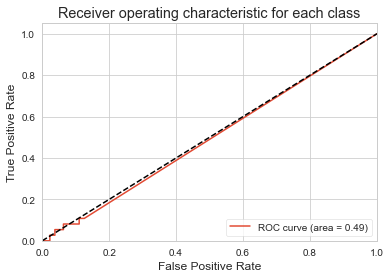

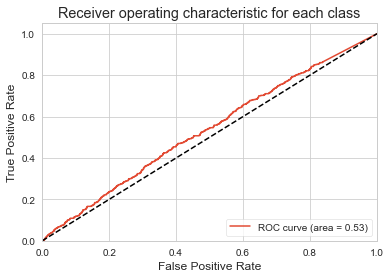

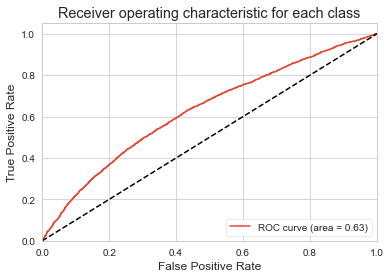

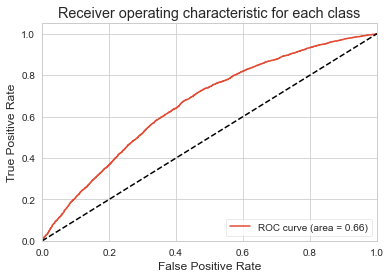

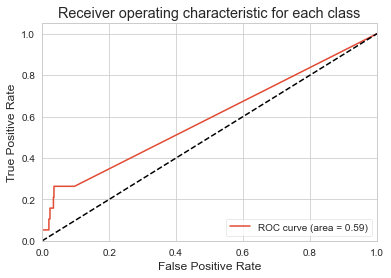

In [355]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()

# Plot confusion metric for KNN

Confusion matrix, without normalization
[[   0    0   28    9    0]
 [   0    0  391   96    0]
 [   0    0 4254 1330    0]
 [   0    0 2802 1682    0]
 [   0    0   10    9    0]]
Normalized confusion matrix
[[0.   0.   0.76 0.24 0.  ]
 [0.   0.   0.8  0.2  0.  ]
 [0.   0.   0.76 0.24 0.  ]
 [0.   0.   0.62 0.38 0.  ]
 [0.   0.   0.53 0.47 0.  ]]


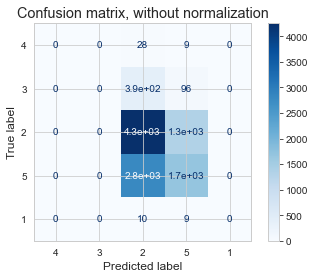

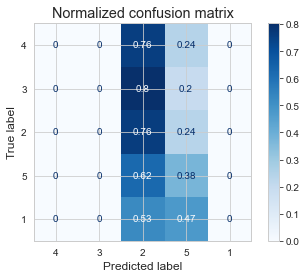

In [356]:
from sklearn.metrics import plot_confusion_matrix        
#set X with our desired variables

X =df[['age','bmi','cholesterol','gluc','smoke','alco','active','cardio']].values
y = df['bp'].values
class_names = df.bp.unique()
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
        
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

#knn = KNeighborsClassifier(n_neighbors=40)
#clf = OneVsRestClassifier(knn)
#y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

base_lr = KNeighborsClassifier(n_neighbors=40)
ovr = OneVsRestClassifier(base_lr)
classifier = ovr.fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

